In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ==========================================
# 1. CÀI ĐẶT THƯ VIỆN & IMPORT
# ==========================================
!pip install -q timm einops peft wandb deepspeed accelerate bitsandbytes decord tensorboardX
!pip install -q datasets jiwer pandas openpyxl
!pip install transformers==4.47.0

In [ ]:
import json
import os
import re
import torch
import numpy as np
import pandas as pd
import torchvision.transforms as T
from PIL import Image
from tqdm import tqdm
from jiwer import cer, wer
from datetime import datetime
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer

# ==========================================
# 2. CẤU HÌNH ĐƯỜNG DẪN
# ==========================================
# Thư mục gốc chứa dữ liệu
BASE_DATA_DIR = "/content/drive/MyDrive/KLTN/data/"

# Thư mục lưu kết quả
OUTPUT_DIR = "/content/drive/MyDrive/KLTN/results_output/"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")


EVAL_DETAILS_PATH = os.path.join(OUTPUT_DIR, f"eval_details_{timestamp}.jsonl")
SUMMARY_EXCEL_PATH = os.path.join(OUTPUT_DIR, f"eval_summary_{timestamp}.xlsx")
RAG_CORPUS_PATH = os.path.join(OUTPUT_DIR, "rag_corpus_final.jsonl")

print(f"--- CẤU HÌNH ---")
print(f"Input: {BASE_DATA_DIR}")
print(f"Output Eval: {SUMMARY_EXCEL_PATH}")
print(f"Output RAG: {RAG_CORPUS_PATH}")

# ==========================================
# 3. CÁC HÀM HỖ TRỢ XỬ LÝ ẢNH & TEXT
# ==========================================
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    return T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height
    target_ratios = sorted([(i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if i * j <= max_num], key=lambda x: x[0] * x[1])
    target_aspect_ratio = find_closest_aspect_ratio(aspect_ratio, target_ratios, orig_width, orig_height, image_size)
    target_width, target_height = image_size * target_aspect_ratio[0], image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]
    resized_img = image.resize((target_width, target_height))
    processed_images = [resized_img.crop(((i % (target_width // image_size)) * image_size, (i // (target_width // image_size)) * image_size, ((i % (target_width // image_size)) + 1) * image_size, ((i // (target_width // image_size)) + 1) * image_size)) for i in range(blocks)]
    if use_thumbnail and len(processed_images) != 1: processed_images.append(image.resize((image_size, image_size)))
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    return torch.stack([transform(img) for img in images])

def clean_text_for_metric(text):
    """Chuẩn hóa text để tính CER/WER chính xác"""
    if not text: return ""
    text = text.lower()
    text = re.sub(r'[\r\n\t]+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# ==========================================
# 4. TẢI MODEL VINTERN
# ==========================================
if not os.path.exists("pretrained/Vintern-1B-v3_5"):
    print("Downloading Model...")
    !mkdir -p pretrained
    !huggingface-cli download --resume-download --local-dir-use-symlinks False 5CD-AI/Vintern-1B-v3_5 --local-dir pretrained/Vintern-1B-v3_5

model_path = "pretrained/Vintern-1B-v3_5"
print(f"Loading model from {model_path}...")

tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True, use_fast=False)
model = AutoModel.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    trust_remote_code=True,
    use_flash_attn=False
).eval().cuda()

# ==========================================
# 5. CHUẨN BỊ DỮ LIỆU
# ==========================================
print("\n--- SCANNING DATA ---")
all_tasks = []

for doc_name in os.listdir(BASE_DATA_DIR):
    doc_path = os.path.join(BASE_DATA_DIR, doc_name)
    if not os.path.isdir(doc_path): continue

    # 1. Đọc JSON OCR gốc
    json_path = os.path.join(doc_path, 'text_data', 'data.json')
    doc_data = []
    if os.path.exists(json_path):
        try:
            with open(json_path, 'r', encoding='utf-8') as f:
                doc_data = json.load(f)
        except:
            print(f"Warning: Lỗi đọc JSON {doc_name}")

    # 2. Tìm ảnh
    all_files = os.listdir(doc_path)
    image_files = sorted([f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    for img_name in image_files:
        try:
            # Lấy số trang từ tên file
            page_num_str = "".join(filter(str.isdigit, img_name))
            page_index = int(page_num_str) - 1 if page_num_str else -1
        except:
            page_index = -1

        # Lấy Ground Truth
        gt_text = ""
        if 0 <= page_index < len(doc_data):
            gt_text = " ".join(doc_data[page_index].get('textContent', []))

        all_tasks.append({
            "id": f"{doc_name}_{img_name}",
            "doc_name": doc_name,
            "filename": img_name,
            "image_path": os.path.join(doc_path, img_name),
            "ground_truth": gt_text,
            "page_num": page_index + 1
        })

print(f"Tổng số trang tài liệu cần xử lý: {len(all_tasks)}")

# ==========================================
# 6. VÒNG LẶP CHÍNH
# ==========================================
print("\n--- BẮT ĐẦU XỬ LÝ ---")

f_eval = open(EVAL_DETAILS_PATH, 'w', encoding='utf-8')
f_rag = open(RAG_CORPUS_PATH, 'w', encoding='utf-8')

success_count = 0

for i, task in enumerate(tqdm(all_tasks, desc="Processing")):
    try:
        # A. Xử lý ảnh & Inference
        pixel_values = load_image(task['image_path'], max_num=12).to(torch.bfloat16).cuda()

        # Prompt tối ưu cho RAG
        question = '<image>\nTrích xuất toàn bộ nội dung văn bản trong ảnh, giữ nguyên định dạng tiêu đề và danh sách dưới dạng Markdown.'
        generation_config = dict(max_new_tokens=1024, do_sample=False, num_beams=3, repetition_penalty=2.0)

        pred_text = model.chat(tokenizer, pixel_values, question, generation_config)

        # B. Đánh giá (Evaluation)
        c_err, w_err = 1.0, 1.0
        if task['ground_truth'].strip():
            gt_clean = clean_text_for_metric(task['ground_truth'])
            pred_clean = clean_text_for_metric(pred_text)
            if gt_clean:
                c_err = cer(gt_clean, pred_clean)
                w_err = wer(gt_clean, pred_clean)

        # C. Ghi file Eval Details
        eval_entry = {
            "id": task['id'],
            "ground_truth": task['ground_truth'],
            "prediction": pred_text,
            "cer": c_err,
            "wer": w_err,
            "image_path": task['image_path']
        }
        f_eval.write(json.dumps(eval_entry, ensure_ascii=False) + '\n')
        f_eval.flush()

        # D. Ghi file RAG Corpus (Chỉ lưu nếu có nội dung)
        if len(pred_text.strip()) > 10:
            rag_entry = {
                "page_content": pred_text,
                "metadata": {
                    "source": task['doc_name'],
                    "page": task['page_num'],
                    "file_name": task['filename'],
                    "processed_date": datetime.now().isoformat()
                }
            }
            f_rag.write(json.dumps(rag_entry, ensure_ascii=False) + '\n')
            f_rag.flush()

        success_count += 1

    except Exception as e:
        print(f"\n[Lỗi] {task['id']}: {e}")
        f_eval.write(json.dumps({"id": task['id'], "error": str(e)}, ensure_ascii=False) + '\n')

    # Dọn dẹp GPU
    if i % 10 == 0:
        torch.cuda.empty_cache()

f_eval.close()
f_rag.close()

# ==========================================
# 7. TỔNG HỢP BÁO CÁO
# ==========================================
print("\n--- TẠO BÁO CÁO TỔNG HỢP ---")
try:
    df = pd.read_json(EVAL_DETAILS_PATH, lines=True)
    # Lọc mẫu thành công
    df_clean = df[df['error'].isna() if 'error' in df.columns else True]

    if not df_clean.empty and 'cer' in df_clean.columns:
        avg_cer = df_clean['cer'].mean()
        avg_wer = df_clean['wer'].mean()

        print(f"\n=== KẾT QUẢ TRUNG BÌNH ({len(df_clean)} mẫu) ===")
        print(f"Character Accuracy: {(1-avg_cer)*100:.2f}%")
        print(f"Word Accuracy:      {(1-avg_wer)*100:.2f}%")

        df_clean.to_excel(SUMMARY_EXCEL_PATH, index=False)
        print(f"Đã lưu Excel tại: {SUMMARY_EXCEL_PATH}")
    else:
        print("Không có dữ liệu hợp lệ để tính toán.")
except Exception as e:
    print(f"Lỗi tạo báo cáo: {e}")

print(f"\nĐã lưu dữ liệu RAG tại: {RAG_CORPUS_PATH}")

--- CẤU HÌNH ---
Input: /content/drive/MyDrive/KLTN/data/
Output Eval: /content/drive/MyDrive/KLTN/results_output/eval_summary_20251220_053949.xlsx
Output RAG: /content/drive/MyDrive/KLTN/results_output/rag_corpus_final.jsonl
Loading model from pretrained/Vintern-1B-v3_5...

--- SCANNING DATA ---
Tổng số trang tài liệu cần xử lý: 174

--- BẮT ĐẦU XỬ LÝ ---


Processing:   0%|          | 0/174 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (3415 > 1700). Running this sequence through the model will result in indexing errors
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Processing: 100%|██████████| 174/174 [1:45:54<00:00, 36.52s/it]


--- TẠO BÁO CÁO TỔNG HỢP ---
Lỗi tạo báo cáo: True

Đã lưu dữ liệu RAG tại: /content/drive/MyDrive/KLTN/results_output/rag_corpus_final.jsonl


BÁO CÁO ĐÁNH GIÁ OCR (174 mẫu)
1. Độ chính xác ký tự (Character Accuracy): 77.21%
   - CER trung bình: 0.2279
2. Độ chính xác từ (Word Accuracy):      75.01%
   - WER trung bình: 0.2499
3. Số mẫu hoàn hảo (100% đúng):          3 mẫu (1.7%)
----------------------------------------

TOP 5 MẪU CÓ KẾT QUẢ KÉM NHẤT (Dựa trên CER):
- ID: PHỤ LỤC NHỮNG ĐIỀU SINH VIÊN KHÔNG ĐƯỢC LÀM; NỘI DUNG VI PHẠM VÀ HÌNH THỨC XỬ LÝ SINH VIÊN_page_007.png
  CER: 2.3004 | WER: 2.5326
  Ghi ...
  Pred (AI): | TT | Nội dung vi phạm | Số lần vi phạm và hình thức xử lý (Số lần tính trong cả khóa học) | Ghi ch...
--------------------
- ID: QUY CHẾ ĐÁNH GIÁ KẾT QUẢ RÈN LUYỆN CỦA SINH VIÊN TRÌNH ĐỘ ĐẠI HỌC HỆ CHÍNH QUY_page_008.png
  CER: 0.8985 | WER: 1.1615
  Học kỳ 1, học kỳ 2, ...
  Pred (AI): # Quy trình đánh giá kết quả rèn luyện  **Điều 13. Quy trình đánh giá kết quả rèn luyện**  Các bước ...
--------------------
- ID: QUY CHẾ CÔNG TÁC SINH VIÊN_page_019.png
  

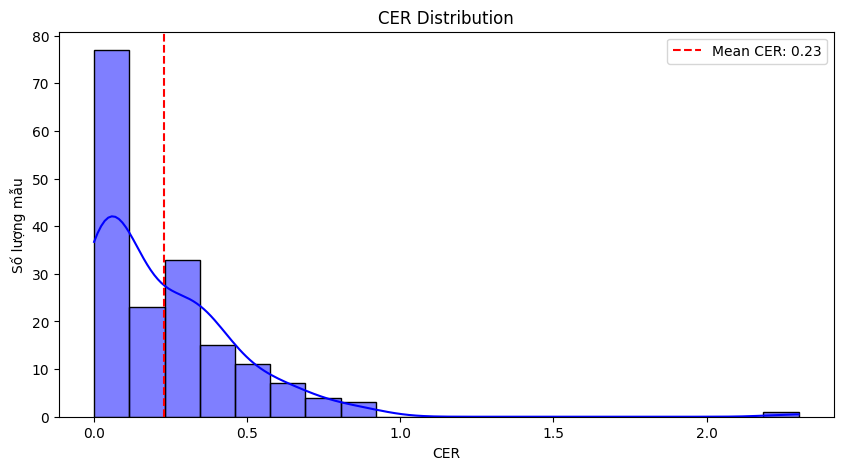

In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc file JSONL
data = []
file_path = '/content/drive/MyDrive/KLTN/results_output/eval_details_20251220_053949.jsonl'

with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        try:
            data.append(json.loads(line))
        except:
            continue

df = pd.DataFrame(data)

# Tính toán các chỉ số trung bình
avg_cer = df['cer'].mean()
avg_wer = df['wer'].mean()
total_samples = len(df)
perfect_samples = df[df['cer'] == 0].shape[0]

print("="*40)
print(f"BÁO CÁO ĐÁNH GIÁ OCR ({total_samples} mẫu)")
print("="*40)
print(f"1. Độ chính xác ký tự (Character Accuracy): {(1 - avg_cer)*100:.2f}%")
print(f"   - CER trung bình: {avg_cer:.4f}")
print(f"2. Độ chính xác từ (Word Accuracy):      {(1 - avg_wer)*100:.2f}%")
print(f"   - WER trung bình: {avg_wer:.4f}")
print(f"3. Số mẫu hoàn hảo (100% đúng):          {perfect_samples} mẫu ({perfect_samples/total_samples*100:.1f}%)")
print("-" * 40)

# 3. Phân tích các mẫu lỗi nặng nhất (Top 5 worst cases)
print("\nTOP 5 MẪU CÓ KẾT QUẢ KÉM NHẤT (Dựa trên CER):")
worst_cases = df.sort_values(by='cer', ascending=False).head(5)
for index, row in worst_cases.iterrows():
    print(f"- ID: {row['id']}")
    print(f"  CER: {row['cer']:.4f} | WER: {row['wer']:.4f}")
    # In ra 100 ký tự đầu để so sánh
    print(f"  GT (Gốc):  {row['ground_truth'][:100].replace(chr(10), ' ')}...")
    print(f"  Pred (AI): {row['prediction'][:100].replace(chr(10), ' ')}...")
    print("-" * 20)

# 4. Vẽ biểu đồ phân phối lỗi
plt.figure(figsize=(10, 5))
sns.histplot(df['cer'], bins=20, kde=True, color='blue')
plt.title('CER Distribution')
plt.xlabel('CER')
plt.ylabel('Số lượng mẫu')
plt.axvline(avg_cer, color='red', linestyle='--', label=f'Mean CER: {avg_cer:.2f}')
plt.legend()
plt.show()